In [3]:
import os
import pickle
import PIL.Image
import numpy as np
import pandas as pd
import csv
import sys
from pathlib import Path

# test

import matplotlib.pyplot as plt
%matplotlib inline

# path to stylegan encoder on server
sys.path.insert(1, '/home/shavit/APhotoADay/data/stylegan-encoder')

import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator

from IPython.display import Markdown, display

from IPython.display import Markdown, display

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [11]:
URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

ValueError: Variable learnable_dlatents already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/home/shavit/APhotoADay/data/stylegan-encoder/encoder/generator_model.py", line 15, in create_variable_for_generator
    initializer=tf.initializers.random_normal())
  File "/home/shavit/APhotoADay/data/stylegan-encoder/dnnlib/tflib/network.py", line 406, in <listcomp>
    in_expr = [input_builder(name) for input_builder, name in zip(custom_inputs, self.input_names)]
  File "/home/shavit/APhotoADay/data/stylegan-encoder/dnnlib/tflib/network.py", line 406, in run
    in_expr = [input_builder(name) for input_builder, name in zip(custom_inputs, self.input_names)]


In [6]:
def generate_image(latent_vector, size):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((size, size))

def show(latent_vector):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    ax[i].imshow(generate_image(latent_vector))
    ax[i].set_title(latent_vector)
    [x.axis('off') for x in ax]
    plt.show()

In [14]:
#    Given a data set of the form
#    ((original photo, original age, target age), target photo)
#    We take some part of the data set and use it to train a linear model
#    We reserve some of the data to test it afterwards

#    photos should be npy
#    input = lists of the data (should all be the same size and flattened)
#    output = linear regression interpolator
#    note that data can come from multiple people, the more data, the more accurate

def findRegressor(start_photos, start_ages, target_ages, target_photos):

    X = []
    Y = []

    for i in range(len(start_photos)):
        X.append(np.concatenate([start_photos[i], start_ages[i], target_ages[i]], axis=None))
        Y.append(target_photos[i])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

    regressor = LinearRegression(copy_X = True)  
    regressor.fit(X_train, Y_train)

    #print("accuracy = " + str(testModel(X_train, Y_train, regressor)))

    return regressor, X_test, Y_test, X_train, Y_train

#    input = list of data to test on and regressor to test
#    output = accuracy in MSE
def testModel(X, Y, regressor):

    Y_pred = regressor.predict (X)
    return Y_pred

Enter number of people:  1
Enter path for data for person 1:  video1


155
train data size = 124
test data size = 31
1.5442318e-08
0.010629255


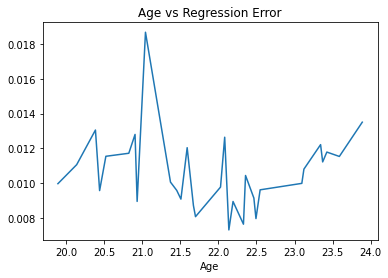

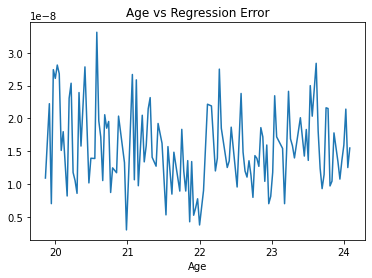

In [32]:
# Receive input

os.chdir("/home/shavit/APhotoADay/True_vs_Learned")

num_of_people = int(input("Enter number of people: "))

paths = []

for person in range(num_of_people):
    paths.append("regression_data/" + input("Enter path for data for person " + str(person + 1) + ": "))
    paths.append("regression_data/video" + str(person + 1))
    
start_photos = []
start_ages = []
target_ages = []
target_photos = []

first = []
first_age = []

for person in range(num_of_people):
    unsorted_files = os.listdir(paths[person])
    naked_files = sorted(unsorted_files, key=lambda x: int(os.path.splitext(x)[0]))
    
    files = []
    
    for file in naked_files:
        files.append(paths[person] + "/" + file)
    
    first.append(np.load(files[0]).flatten())
    first_age.append(int(Path(files[0]).stem))
    
    for i in range(len(files)):
        if (i > 30):
            start_photos.append(np.load(files[i - 30]).flatten())
            start_ages.append(int(Path(files[i - 30]).stem))
            target_ages.append(int(Path(files[i]).stem))
            target_photos.append(np.load(files[i]).flatten())

print (len(start_photos))
#for i in range (len(start_photos):
#    print(start_photos[i], start_ages[i], target_ages[i], target_photos[i])
    
regressor, X_test, Y_test, X_train, Y_train = findRegressor(start_photos, start_ages, target_ages, target_photos)

print ("train data size = " + str(len(X_train)))
print ("test data size = " + str(len(X_test)))


Y_pred = testModel(X_test, Y_test, regressor)
MSE = metrics.mean_squared_error (Y_test, Y_pred)
MSE_train = metrics.mean_squared_error (regressor.predict(X_train), Y_train)
Y_pred_train = testModel (X_train, Y_train, regressor)
print (MSE_train)
print (MSE)

# print (X_test[0].shape)

# New code
age_specific_MSE = []
age_specific_MSE_train = []


for i, age in enumerate(Y_pred):
    this_MSE = metrics.mean_squared_error (np.array(Y_pred[i]), np.array(Y_test[i]))
    age_specific_MSE.append([X_test[i][9217], this_MSE])


    
for i, age in enumerate(Y_train):
    this_MSE = metrics.mean_squared_error (Y_pred_train[i], Y_train[i])
    age_specific_MSE_train.append([X_train[i][9217], this_MSE])

    
age_specific_MSE.sort()

# print (age_specific_MSE)

graph_name = "regression_data/graphs/graph1"
csv_file = graph_name + ".csv"

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Age", "MSE"])
    
    for age, mse in age_specific_MSE:
        writer.writerow([(age / 365.0), mse])

# Display and save plot

data = pd.read_csv(csv_file).set_index('Age')
data_plot = data.plot(title = "Age vs Regression Error", legend = None)

data_plot.get_figure().savefig(graph_name + ".png")

graph_name_train = "regression_data/graphs/graph1_train"
csv_file_train = graph_name_train + ".csv"

age_specific_MSE_train.sort()

with open(csv_file_train, 'w', newline='') as file_train:
    writer_train = csv.writer(file_train)
    writer_train.writerow(["Age", "MSE"])
    
    for age, mse in age_specific_MSE_train:
        writer_train.writerow([(age / 365.0), mse])

# Display and save plot

data_train = pd.read_csv(csv_file_train).set_index('Age')
data_plot_train = data_train.plot(title = "Age vs Regression Error", legend = None)

data_plot_train.get_figure().savefig(graph_name_train + ".png")

In [10]:
# Video from given picture, using our data (which specific data exactly?)

t_start_photos = []
t_start_ages = []
t_target_ages = []
    
t_first = np.load("regression_data/test/kobi.npy").flatten()
t_first_age = int(input("Enter your age (years): ")) * 365

for i in range (t_first_age, t_first_age * 2, 10):
    t_start_photos.append(t_first)
    t_start_ages.append(t_first_age)
    t_target_ages.append(i)

t_X = []
for i in range(len(t_start_photos)):
    t_X.append(np.concatenate([t_start_photos[i], t_start_ages[i], t_target_ages[i]], axis=None))

results_path = "regression_data/results"

t_Y = regressor.predict(t_X)

if not os.path.exists(results_path):
    os.mkdir(results_path)

for i, prediction in enumerate(t_Y):
    img = generate_image(prediction, 512)
    img.save(results_path + "/" + str(i) + ".png")

Enter your age (years):  20


NameError: name 'generator' is not defined